## Code used for comparison of prediction performance and batch size

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wantd values and return a string

In [2]:
def parse(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    got = False
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                pstr += str(spline[c]) + ','
            pstr += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        else:
            for c in columns:
                pstr += str(spline[c]) + ','
            if len(columns) == 5:
                pstr += '0,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [3]:
def load_df(filename):
    df = pd.read_csv(filename)
    return select_columns_and_rename_values(df)

In [4]:
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
#     df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [5]:
def filter_by_substring_algorithm(df, string):
    return df[df['algorithm'].str.contains(string, regex=False)]

**Auxiliary methods for graph generation**

*_markers* suffix indicates a graph with markers

In [6]:
def gen_lines(df, ax, alg_order):
    colors=['g', 'b', 'r', 'm', 'y' , 'k']
    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', label=f'{alg}-prec')
    ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,100)

In [7]:
def gen_lines_markers(df, ax, alg_order):
    lwidth = 0.75
    colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [8]:
def gen_graph(df):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
#     datasets = ['elecNormNew']
    algs = ['ARFMB', 'LBagMB', 'SRPMB', 'OBAdwinMB', 'OBASHTMB', 'OBMB']
#     algs = ['ARFMB', 'LBagMB', 'SRPMB', 'OBAdwinMB', 'OBMB']
#     datasets = ['elecNormNew']
    
    algs = ['OB']
    fig, axs = plt.subplots(2, 2, figsize=(8,4), sharey='row')
    filename = f"batch-size-vs-prediction"
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        ax = axs[int(my_id/2)][my_id%2]
        for i in algs:
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), i)
            df_aux = df_aux[df_aux.batch_size != 1]
            gen_lines(df_aux, ax, algs.index(i))
            ax.set_title(f'{ds}')
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = len(algs), bbox_to_anchor=(0.5,-0.05))
    fig.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.savefig(f'{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [130]:
def gen_graph_markers(df):
#     datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    datasets = ['elecNormNew']
    
    algs = ['OB']
#     algs = ['ARFMB', 'LBagMB', 'SRPMB', 'OBAdwinMB', 'OBASHTMB', 'OBMB']
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = f"batch-size-vs-prediction"
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        ax = axs[int(my_id/2)][my_id%2]
        for i in algs:
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), i)
            display(df_aux)
            df_aux = df_aux[df_aux.batch_size != 1]
            gen_lines_markers(df_aux, ax, algs.index(i))
            ax.set_title(f'{dsformalname[ds]}')
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algs)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'{filename}-mark.png')
    plt.savefig(f'{filename}-mark.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the files are located.
- Opens the csv file that will store all parsed strings.
- For each file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop selected columns

In [9]:
def group_by(df):
    return df.groupby(['dataset','algorithm','ensemble_size','batch_size'], as_index=False).mean()

In [10]:
%cd /home/reginaldojunior/Documentos/UFscar/compare-dvfs-moa/results/pi/600/600

folder = "first"
directory = os.fsencode(folder)
header_printed = False

with open(f"{folder}/data.csv", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{folder}/data.csv')
display(group_by(df))
a = df.drop(['cores', 'time'], axis=1)

/home/reginaldojunior/Documentos/UFscar/compare-dvfs-moa/results/pi/600/600


,dataset,algorithm,ensemble_size,batch_size,cores,instances,time,acc,change
0,GMSC,ARFSequential,50,1,1,1510.0,36.379002,94.105960,0.0
1,GMSC,LBagSequential,50,1,1,2250.0,35.207001,94.044444,0.0
2,GMSC,OB,50,1,1,8770.0,33.591999,93.580388,0.0
3,GMSC,OBASHTSequential,50,1,1,9310.0,34.347000,93.641246,NaN
4,GMSC,OBAdwinSequential,50,1,1,7070.0,35.387001,93.663366,1.0
5,GMSC,SRPSequential,50,1,1,750.0,36.201000,94.133333,0.0
6,airlines,ARFSequential,50,1,1,210.0,37.978001,67.142857,0.0
7,airlines,LBagSequential,50,1,1,130.0,40.507999,72.307692,0.0
8,airlines,OB,50,1,1,310.0,38.015999,77.419355,0.0
9,airlines,OBASHTSequential,50,1,1,390.0,39.129002,78.461538,0.0


In [11]:
a.dtypes

dataset           object
algorithm         object
ensemble_size      int64
batch_size         int64
instances        float64
acc              float64
prec              object
recall            object
change           float64
dtype: object

**show graphs and tables**

In [12]:
display(a[a.batch_size == 1].sort_values(by=['dataset', 'algorithm']))

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
41,GMSC,ARFSequential,50,1,1510.0,94.105960,63.901843215634024,51.53351188920826,0.0
25,GMSC,LBagSequential,50,1,2250.0,94.044444,68.01603312805267,54.997496465598495,0.0
1,GMSC,OB,50,1,8770.0,93.580388,60.18084903864458,50.2927533794732,0.0
3,GMSC,OBASHTSequential,50,1,9310.0,93.641246,75.0,51.2,NaN
6,GMSC,OBAdwinSequential,50,1,7070.0,93.663366,58.435159852192584,50.264709896630244,1.0
15,GMSC,SRPSequential,50,1,750.0,94.133333,63.85542168674698,51.02134798197427,0.0
38,airlines,ARFSequential,50,1,210.0,67.142857,49.14529914529915,49.24443266171792,0.0
32,airlines,LBagSequential,50,1,130.0,72.307692,57.996632996633004,56.333333333333336,0.0
10,airlines,OB,50,1,310.0,77.419355,61.85410334346504,55.81222056631893,0.0
29,airlines,OBASHTSequential,50,1,390.0,78.461538,61.675824175824175,54.45564516129032,0.0


IndexError: index 0 is out of bounds for axis 0 with size 0

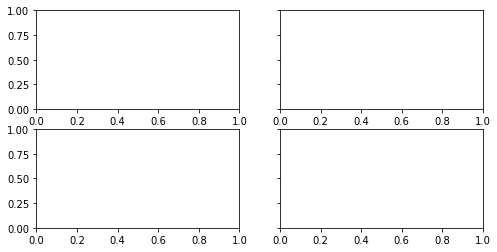

In [13]:
gen_graph(a)

In [19]:
def gen_graph_markers(df):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
#     datasets = ['elecNormNew']

    algs = ['ARFMB', 'LBagMB', 'SRPMB', 'OBAdwinMB', 'OBMB']
    algs = ['ARFMB', 'LBagMB', 'SRPMB', 'OBAdwinMB', 'OBASHTMB', 'OBMB']
#     algs = ['OB', 'OBRUNPER']
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = f"batch-size-vs-prediction"
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        ax = axs[int(my_id/2)][my_id%2]
        for i in algs:
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), i)
            display(df_aux)
#             df_aux = df_aux[df_aux.batch_size != 1]
            gen_lines_markers(df_aux, ax, algs.index(i))
            ax.set_title(f'{dsformalname[ds]}')
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algs)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'{filename}-mark.png')
    plt.savefig(f'{filename}-mark.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


IndexError: index 0 is out of bounds for axis 0 with size 0

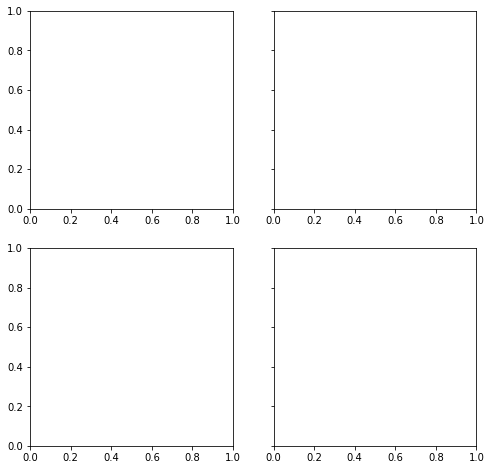

In [20]:
gen_graph_markers(a)

In [18]:
for ai in a.dataset.unique():
    for s in a.ensemble_size.unique():
        for alg in ['L', 'Adwin']:
            aux = filter_by_substring_algorithm(a[(a.ensemble_size == s) & (a.dataset == ai)].
                                                sort_values(['ensemble_size','batch_size']), alg)
            display(aux)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
8,elecNormNew,LBagRUNPER,100,1,45312.0,89.214778,89.24611870594656,88.61274566216002,482.0
9,elecNormNew,LBagSequential,100,1,45312.0,89.159605,89.1826382935279,88.56208057429278,462.0
0,elecNormNew,LBagMB,100,50,NaN,NaN,NaN,NaN,NaN


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
40,elecNormNew,LBagSequential,50,1,960.0,89.583333,89.58024991427914,89.61876832844575,2.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
34,elecNormNew,OBAdwinSequential,50,1,4040.0,89.579208,89.11573754568923,89.14043855092457,32.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
35,elecNormNew,LBagSequential,150,1,45312.0,88.709393,88.71871726593564,88.09728715202124,539.0
42,elecNormNew,LBagRUNPER,150,1,45312.0,88.698358,88.6902688349554,88.10269489559784,540.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
25,GMSC,LBagSequential,50,1,2250.0,94.044444,68.01603312805267,54.997496465598495,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
6,GMSC,OBAdwinSequential,50,1,7070.0,93.663366,58.435159852192584,50.264709896630244,1.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
32,airlines,LBagSequential,50,1,130.0,72.307692,57.996632996633004,56.333333333333336,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
12,airlines,OBAdwinSequential,50,1,310.0,77.419355,61.85410334346504,55.81222056631893,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
43,covtypeNorm,LBagSequential,50,1,840.0,70.238095,?,?,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
22,covtypeNorm,OBAdwinSequential,50,1,880.0,67.954545,?,?,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
